# Austin's Car Crash
#### By: Luca Comba, Hung Tran, Steven Tran

<img src="https://upload.wikimedia.org/wikipedia/en/thumb/a/a0/Seal_of_Austin%2C_TX.svg/1024px-Seal_of_Austin%2C_TX.svg.png" width="100" height="100">

#### Table of Contents
1. [Introduction](#introduction)
2. [Data](#data)
3. [Models](#models)
4. [Conclusion](#conclusion)


# Introduction

<div id="introduction" />

The original dataset includes records of traffic accidents in Austin, Texas, from 2010 to today, with 216,088 instances and 45 features, including both numerical and categorical data. The dataset can be found at [Austin Crash Report Data](https://catalog.data.gov/dataset/vision-zero-crash-report-data).

# Data
<div id="data" />

In the following section we will set up the dataset and the features we will be using for our models.

In [1]:
# imports
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

import matplotlib.pyplot as plt

from utils.utils import (
    print_linear_regression_scores,
    backwards_elimination,
    Timer,
    Pickler
)

RANDOM_SEED=42
REDUCED_DATASET = True
REDUCED_FRACTION = 0.1

In [2]:
# read data
df = pd.read_csv('data/austin_car_crash_cleaned.csv')

## Data Cleaning

We went over the dataset cleansing in the file [cleaning.ipynb](./cleaning.ipynb).


## Exploratory Data Analysis

We went over the exploratory data analysis in the file [exploratory.ipynb](./exploratory.ipynb).

## Feature Selection
<div id="feature-selection" />

We ran the [feature_selection.ipynb](./feature_selection.ipynb) notebook for a preview run on the data, and now we will need to drop some features from the dataset.

We will be dropping the `primary_address`, `secondary_address`, `latitude`, `longitude`, and `timestamp_us_central` due to their types.

In [ ]:
df = df.drop(columns=['primary_address', 'secondary_address', 'timestamp_us_central', 'latitude', 'longitude'])

We could have create a new feature with the latitude and longitude and clustering algorithms (e.g., K-Means) to group locations into clusters and use the cluster labels as features.

```python
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
df['location_cluster'] = kmeans.fit_predict(df[['latitude', 'longitude']])
```

### Backward Elimination

After the data split we will be using the **Backward Elimination** method for dropping unsatisfactory features from the dataset.

In [4]:
target_col = 'estimated_total_comprehensive_cost'

# Split into features (X) and target (y)
X = df.drop(columns=[target_col]).astype(int)
y = df[target_col]

In [5]:
# Split 70-30 train-test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

In [6]:
X_train, backwards_eliminated_features = backwards_elimination(X_train, y_train)
print(f"Removed features: {backwards_eliminated_features}")

Removed features: ['month', 'construction_zone', 'unit_involved_large_passenger_vehicle', 'month_sin', 'day_of_month', 'unit_involved_pedestrian', 'day_of_week', 'severity_possible_injury', 'severity_incapacitating_injury', 'severity_non_incapacitating_injury', 'law_enforcement_fatality_count', 'unit_involved_bicycle', 'year', 'death_cnt', 'tot_injry_cnt', 'unit_involved_passenger_car', 'month_cos', 'hour_sin', 'unit_involved_other_unknown']


In [7]:
print(f"Number of features before backwards elimination: {len(df.columns)}")

X_train = X_train.drop(columns = ['const'])
X_test = X_test.drop(columns = backwards_eliminated_features)

print(f"Number of features after backwards elimination train: {len(X_train.columns)}")
print(f"Number of features after backwards elimination test: {len(X_test.columns)}")

Number of features before backwards elimination: 47
Number of features after backwards elimination train: 27
Number of features after backwards elimination test: 27


In [8]:
print(f"Features after backwards elimination: {X_train.columns.tolist()}")

Features after backwards elimination: ['fatal_crash', 'speed_limit', 'sus_serious_injry_cnt', 'nonincap_injry_cnt', 'poss_injry_cnt', 'non_injry_cnt', 'unkn_injry_cnt', 'motor_vehicle_death_count', 'motor_vehicle_serious_injury_count', 'bicycle_death_count', 'bicycle_serious_injury_count', 'pedestrian_death_count', 'pedestrian_serious_injury_count', 'motorcycle_death_count', 'motorcycle_serious_injury_count', 'other_death_count', 'other_serious_injury_count', 'micromobility_serious_injury_count', 'micromobility_death_count', 'severity_killed', 'severity_not_injured', 'severity_unknown', 'unit_involved_motor_vehicle_other', 'unit_involved_motorcycle', 'hour', 'weekend', 'hour_cos']


## Feature Scaling

Try dividing your data by 1000 to see if that affects performance. Also exclude number of deaths and focus on speed of crash as a feature. 

In [9]:
# Reduce the y

y_train = y_train / 100000
y_test = y_test / 100000

In [10]:
# Select numeric columns
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

print(f"Numeric columns: {numeric_cols}")

Numeric columns: ['fatal_crash', 'speed_limit', 'sus_serious_injry_cnt', 'nonincap_injry_cnt', 'poss_injry_cnt', 'non_injry_cnt', 'unkn_injry_cnt', 'motor_vehicle_death_count', 'motor_vehicle_serious_injury_count', 'bicycle_death_count', 'bicycle_serious_injury_count', 'pedestrian_death_count', 'pedestrian_serious_injury_count', 'motorcycle_death_count', 'motorcycle_serious_injury_count', 'other_death_count', 'other_serious_injury_count', 'micromobility_serious_injury_count', 'micromobility_death_count', 'severity_killed', 'severity_not_injured', 'severity_unknown', 'unit_involved_motor_vehicle_other', 'unit_involved_motorcycle', 'hour', 'weekend', 'hour_cos']


In [11]:
cols_to_remove = [ 'unit_involved_motor_vehicle_other', 'unit_involved_motorcycle']

# 'unit_involved_bicycle',
# 'unit_involved_large_passenger_vehicle',
# 'unit_involved_motor_vehicle_other',
# 'unit_involved_motorcycle',
# 'unit_involved_other_unknown',
# 'unit_involved_passenger_car',
# 'unit_involved_pedestrian',

for col in cols_to_remove:
    numeric_cols.remove(col)

In [12]:
# Select categorical columns
categorical_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
print(f"Categorical columns: {categorical_cols}")

Categorical columns: []


In [13]:
print(f'Train after scaler. mean: {np.mean(X_train[numeric_cols], axis=0)} std: {np.std(X_train[numeric_cols], axis=0)}')
print(f'Test after scaler. mean: {np.mean(X_test[numeric_cols], axis=0)} std: {np.std(X_test[numeric_cols], axis=0)}')

Train after scaler. mean: fatal_crash                            0.005536
speed_limit                           45.898879
sus_serious_injry_cnt                  0.035196
nonincap_injry_cnt                     0.284108
poss_injry_cnt                         0.359067
non_injry_cnt                          1.846197
unkn_injry_cnt                         0.109186
motor_vehicle_death_count              0.002808
motor_vehicle_serious_injury_count     0.024529
bicycle_death_count                    0.000126
bicycle_serious_injury_count           0.001866
pedestrian_death_count                 0.001767
pedestrian_serious_injury_count        0.003598
motorcycle_death_count                 0.000915
motorcycle_serious_injury_count        0.005186
other_death_count                      0.000000
other_serious_injury_count             0.000018
micromobility_serious_injury_count     0.000000
micromobility_death_count              0.000000
severity_killed                        0.005536
severity_not_i

In [14]:
# Scale numeric features
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [15]:
print(f'Train after scaler. mean: {np.mean(X_train[numeric_cols], axis=0)} std: {np.std(X_train[numeric_cols], axis=0)}')
print(f'Test after scaler. mean: {np.mean(X_test[numeric_cols], axis=0)} std: {np.std(X_test[numeric_cols], axis=0)}')

Train after scaler. mean: fatal_crash                          -3.072659e-17
speed_limit                           1.296636e-16
sus_serious_injry_cnt                -3.273465e-17
nonincap_injry_cnt                   -2.996161e-18
poss_injry_cnt                        6.279188e-17
non_injry_cnt                        -3.056722e-17
unkn_injry_cnt                       -1.491706e-17
motor_vehicle_death_count             6.374810e-18
motor_vehicle_serious_injury_count   -3.773888e-17
bicycle_death_count                  -1.211214e-18
bicycle_serious_injury_count          2.613672e-18
pedestrian_death_count               -7.267284e-18
pedestrian_serious_injury_count       2.476614e-17
motorcycle_death_count                4.844856e-18
motorcycle_serious_injury_count       2.722044e-17
other_death_count                     0.000000e+00
other_serious_injury_count           -7.012291e-19
micromobility_serious_injury_count    0.000000e+00
micromobility_death_count             0.000000e+00
sever

# Models
<div id="models" />
We will be using the following models:

To predict the `estimated_total_comprehensive_cost` we can use:
1. Linear Regression
2. Ridge Regression
3. Lasso Regression
4. Decision Tree Regression
5. Random Forest Regression
6. Support Vector Regression (SVR)
7. K-Nearest Neighbors (KNN) Regression

## Pipeline

The sklearn pipeline will help us creating models.

In [16]:
preprocessor = None # No preprocessing needed yet, usually we can run feature scaling and feature selection here

In [17]:
models = {
    'linear_regression': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ]),
    "ridge_regression": Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', Ridge(alpha=1.0))
    ]),
    "lasso_regression": Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', Lasso(alpha=0.1))
    ]),
    "decision_tree_regressor": Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', DecisionTreeRegressor(random_state=RANDOM_SEED))
    ]),
    "random_forest_regressor": Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED, n_jobs=-1))
    ]),
    # SVR needs a better hardware
    "svr": Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', SVR(kernel='rbf', C=1.0, epsilon=0.1))
    ]),
    "k_neighbors_regressor": Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', KNeighborsRegressor(n_neighbors=90, n_jobs=-1))
    ])
}

### Grid Search for hyperparameters tuning

We will be using the `GridSearchCV` method to find the best hyperparameters for our models.

In [18]:
param_grids = {
    'linear_regression': {},
    'ridge_regression': {
        'regressor__alpha': [0.1, 1.0, 10.0]
    },
    'lasso_regression': {
        'regressor__alpha': [0.1, 1.0, 10.0]
    }, 
    'decision_tree_regressor': {
        'regressor__max_depth': [3,5,10],                         
        'regressor__min_samples_split':[2,5,10]
    },
    'random_forest_regressor': {
        'regressor__n_estimators':[50, 100, 200],
        'regressor__max_depth':[3,5,10]
    }, 
    'srv': {
        'regressor__C': [0.1, 1.0, 10.0], # penalty parameter
        'regressor__epsilon': [0.1, 0.2, 0.5], # no pentaly if error is within epsilon
        'regressor__kernel': ['linear', 'rbf']
    }, 
    'k_neighbors_regressor': {
        'regressor__n_neighbors': [3,5,10], # how many neighbors to look at 
        'regressor__weights': ['uniform', 'distance'] # how to weight neighbors
    }
}

In [19]:
models_with_gridsearch = {}

for model_name, model_pipeline in models.items(): 
    param_grid = param_grids.get(model_name, {})
    
    grid_search = GridSearchCV(
        estimator = model_pipeline, 
        param_grid = param_grid, 
        cv = 5, 
        n_jobs = -1, 
        scoring = 'neg_mean_squared_error'
    )
    
    models_with_gridsearch[model_name] = grid_search

# print(f"Models with grid search:\n {models_with_gridsearch}")

### Sample Reduction

In [20]:
if REDUCED_DATASET and REDUCED_FRACTION:
    # reduce dataset to 10% of the original
    X_train = X_train.sample(frac=REDUCED_FRACTION, random_state=RANDOM_SEED)
    y_train = y_train.sample(frac=REDUCED_FRACTION, random_state=RANDOM_SEED)
    X_test = X_test.sample(frac=REDUCED_FRACTION, random_state=RANDOM_SEED)
    y_test = y_test.sample(frac=REDUCED_FRACTION, random_state=RANDOM_SEED)
    print(f"Reduced dataset to {REDUCED_FRACTION*100}% of the original size.")

Reduced dataset to 10.0% of the original size.


### Fitting the model

In [21]:
results = {}
for model_name, grid_search in models_with_gridsearch.items(): 
    print(f"Fitting {model_name} with GridSearchCV")
    with Timer():
        grid_search.fit(X_train, y_train)

    # Predictions
    y_hat_test = grid_search.predict(X_test)
    y_hat_train = grid_search.predict(X_train)

    # Metrics
    test_metrics = print_linear_regression_scores(f"{model_name} - Test", y_test, y_hat_test)
    train_metrics = print_linear_regression_scores(f"{model_name} - Train", y_train, y_hat_train)

    print(f'Best params for {model_name}: {grid_search.best_params_}')
    print(f'Best score for {model_name}: {grid_search.best_score_}')
    print()
    results[model_name] = {
        "y_hat_test": y_hat_test,
        "y_hat_train": y_hat_train,
        "params": grid_search.best_params_,
        "cv_score": grid_search.best_score_,
        "test_metrics": test_metrics,
        "train_metrics": train_metrics
    }


Fitting linear_regression with GridSearchCV
Executed in 2.4329 seconds
linear_regression - Test Scores:
MAE: 0.0058 MSE: 0.0005 RMSE: 0.0217 RMSE%: 0.71% R^2: 1.0000
linear_regression - Train Scores:
MAE: 0.0058 MSE: 0.0009 RMSE: 0.0304 RMSE%: 0.99% R^2: 1.0000
Best params for linear_regression: {}
Best score for linear_regression: -0.0009347575173699524

Fitting ridge_regression with GridSearchCV
Executed in 0.8348 seconds
ridge_regression - Test Scores:
MAE: 0.0058 MSE: 0.0005 RMSE: 0.0217 RMSE%: 0.71% R^2: 1.0000
ridge_regression - Train Scores:
MAE: 0.0058 MSE: 0.0009 RMSE: 0.0304 RMSE%: 0.99% R^2: 1.0000
Best params for ridge_regression: {'regressor__alpha': 0.1}
Best score for ridge_regression: -0.0009351325406451283

Fitting lasso_regression with GridSearchCV
Executed in 0.8476 seconds
lasso_regression - Test Scores:
MAE: 0.1814 MSE: 0.1578 RMSE: 0.3972 RMSE%: 13.07% R^2: 0.9969
lasso_regression - Train Scores:
MAE: 0.1868 MSE: 0.1821 RMSE: 0.4268 RMSE%: 13.89% R^2: 0.9966
Best 

### Linear Regression

In [22]:
linear_regression_grid_search = models_with_gridsearch['linear_regression']
best_linear_regression_pipeline = linear_regression_grid_search.best_estimator_
best_linear_regressor = best_linear_regression_pipeline.named_steps['regressor']

intercept = best_linear_regressor.intercept_
coeffs = best_linear_regressor.coef_
print(f"Intercept: {intercept:.4f}")
print(f"Coefficients: {len(coeffs)}")

Intercept: 3.0739
Coefficients: 27


#### Linear Regression Coefficients

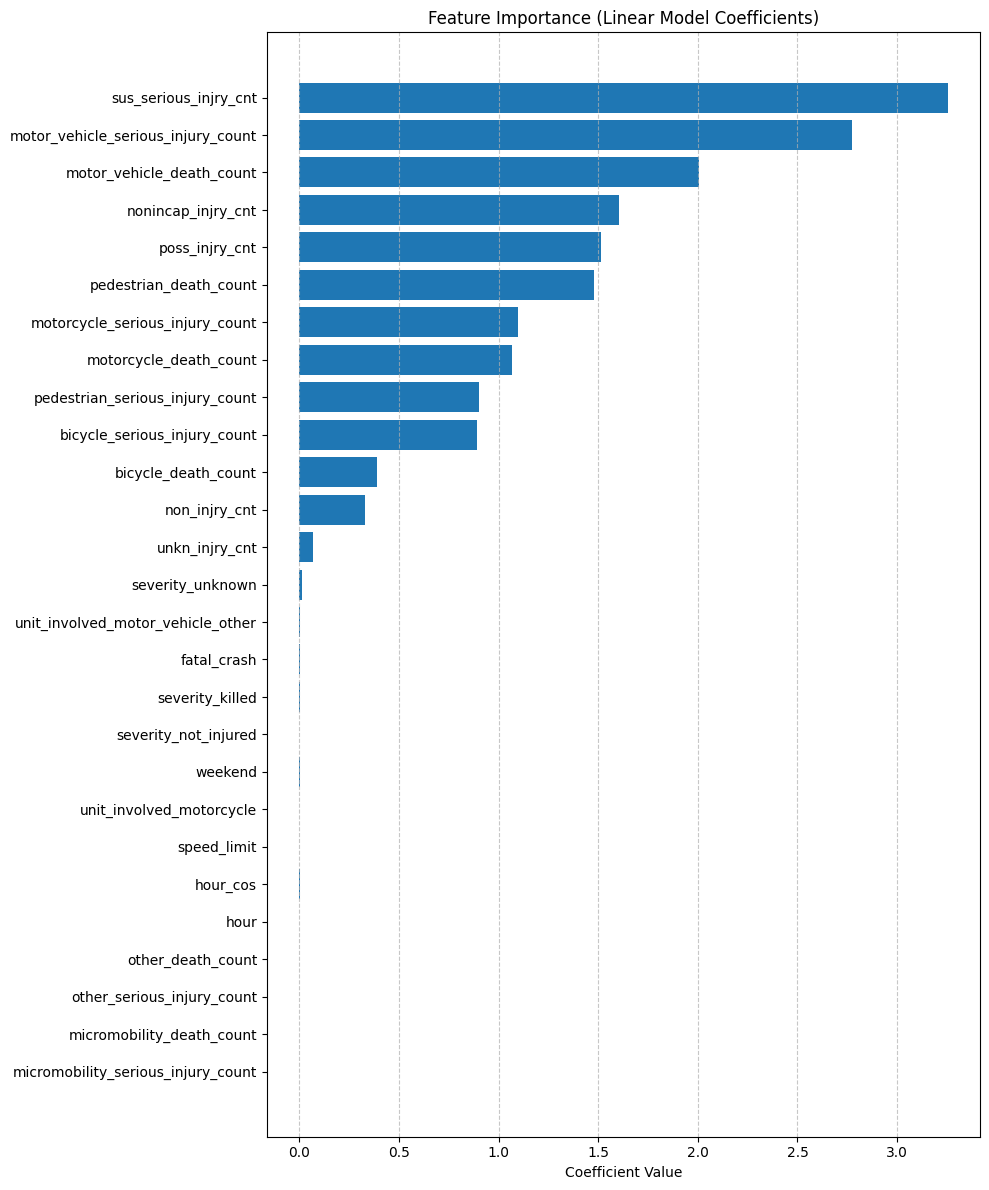

In [23]:
# Get feature names and coefficients
feature_names = X_train.columns
coefficients = coeffs

# Create a DataFrame for easy sorting and plotting
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort by absolute value of coefficient (strongest impact at top)
coef_df_sorted = coef_df.reindex(coef_df.Coefficient.abs().sort_values(ascending=False).index)

# Plotting
plt.figure(figsize=(10, 12))
plt.barh(coef_df_sorted['Feature'], coef_df_sorted['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Feature Importance (Linear Model Coefficients)')
plt.gca().invert_yaxis()  # Most impactful on top
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('./image/linear_regression_feature_importance.png')

### Hyperparameter tuning

We will be using the `GridSearchCV` method to find the best hyperparameters for our models.

In [24]:
# Example of setting a hyperparameter for a model
# models['k_neighbors_regressor'].set_params(regressor__n_neighbors=200)

for model_name in results:
    for param_name, param_value in results[model_name]['params'].items():
        print(f"Setting {model_name} {param_name} to {param_value}")
        models[model_name].set_params(**{param_name: param_value})

Setting ridge_regression regressor__alpha to 0.1
Setting lasso_regression regressor__alpha to 0.1
Setting decision_tree_regressor regressor__max_depth to 10
Setting decision_tree_regressor regressor__min_samples_split to 5
Setting random_forest_regressor regressor__max_depth to 10
Setting random_forest_regressor regressor__n_estimators to 200
Setting k_neighbors_regressor regressor__n_neighbors to 3
Setting k_neighbors_regressor regressor__weights to distance


# Conclusion
<div id="conclusion" />

In this project we have gone over the dataset and created a model to predict the `estimated_total_comprehensive_cost` of a car crash in Austin, Texas. We have used different models and evaluated them using the test set. The best model was the Random Forest Regression with an R2 score of 0.85.

### Saving results

In [25]:
filename = './data/metrics.pkl'
Pickler(filename).save(results)

In [26]:
filename = './data/models.pkl'
Pickler(filename).save((models_with_gridsearch, X_train.columns.tolist()))

In [27]:
filename = './data/scaler.pkl'
data = ( numeric_cols, categorical_cols, scaler)
Pickler(filename).save(data)